In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import diffusion as df
import tqdm

print('Loading model')

model_file = 'model-2-16.h5'

T = 1000
batch_size = 32
embedding_size = 128
input_dim = 64
model = df.build_model_2(T, embedding_size, input_dim)
model.load_weights(f'models/{model_file}')
model.compile(loss=tf.keras.losses.Huber(), optimizer="nadam")
alphas_cumprod, betas, alphas = df.calculate_variance(T)
print('Model loaded')

Loading model
Model loaded


(-0.5, 27.5, 27.5, -0.5)

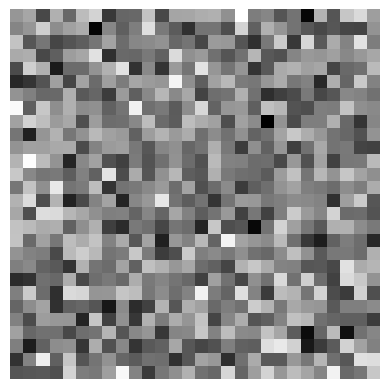

In [2]:
noise = np.random.normal(0, 1, (1, 28, 28, 1))

plt.imshow(noise[0, :, :, 0], cmap='gray')
plt.axis('off')

1/1 [==============================] - 1s 1s/step


(-0.5, 27.5, 27.5, -0.5)

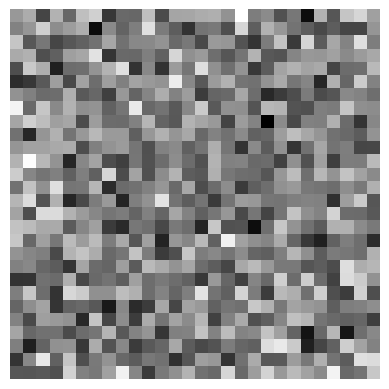

In [3]:
predicted = model.predict({
    "X_Noisy": noise, 
    "t_Input": np.array([800]), 
    # one-hot encoding of the time step
    "c_Input": tf.one_hot([0], 10, dtype=tf.float32)
}, batch_size=batch_size)


plt.figure()
plt.imshow(predicted[0, :, :, 0], cmap='gray')
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

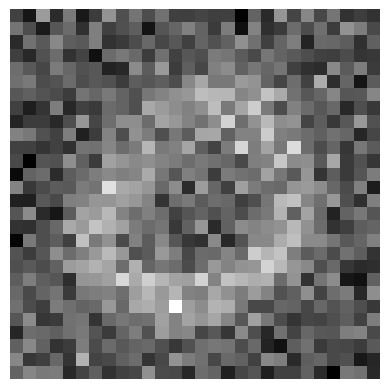

In [4]:
# subtract noise in one step
subtracted = noise - predicted

plt.figure()
plt.imshow(subtracted[0, :, :, 0], cmap='gray')
plt.axis('off')

In [5]:
# predict for all values of t
predicted = model.predict({
    # noise, 1000 time steps
    "X_Noisy": np.repeat(noise, 1000, axis=0),
    # time step
    "t_Input": np.arange(1000),
    # one-hot encoding of the time step
    "c_Input": tf.one_hot(np.zeros(1000), 10, dtype=tf.float32)
}, batch_size=batch_size)

32/32 [==============================] - 0s 11ms/step


100%|█████████▉| 999/1000 [00:57<00:00, 19.68it/s]

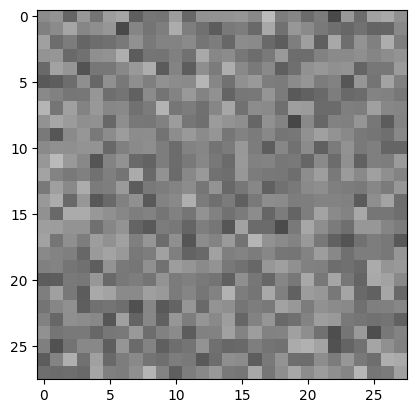

In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

images = [predicted[i, :, :, 0] for i in range(1000)]

# Use blitting
fig, ax = plt.subplots()
im = ax.imshow(images[0], cmap='gray')

def init():
    im.set_data(images[0])
    return [im]

def update(i):
    im.set_data(images[i])
    return [im]

ani = matplotlib.animation.FuncAnimation(fig, update, frames=tqdm.tqdm(range(1000)), init_func=init, blit=True, interval=10)

from IPython.display import HTML #type: ignore
HTML(ani.to_html5_video())

In [7]:
generated = df.generate_return_all_context(
    model, 1, 2, T, alphas, betas, alphas_cumprod
)

100%|██████████| 999/999 [01:04<00:00, 15.53it/s]]


In [8]:
generated = np.array(generated)
generated.shape

(999, 1, 28, 28, 1)

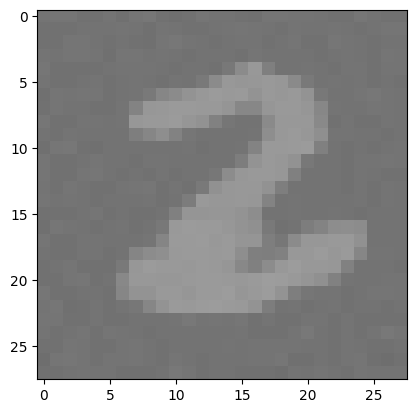

In [9]:
# build same animation for generated images
images = [generated[i][0] for i in range(999)]
# Use blitting
fig, ax = plt.subplots()
im = ax.imshow(images[0], cmap='gray')

def init():
    im.set_data(images[0])
    return [im]

def update(i):
    im.set_data(images[i])
    return [im]

ani = matplotlib.animation.FuncAnimation(fig, update, frames=tqdm.tqdm(range(999)), init_func=init, blit=True, interval=10)

from IPython.display import HTML #type: ignore
HTML(ani.to_html5_video())

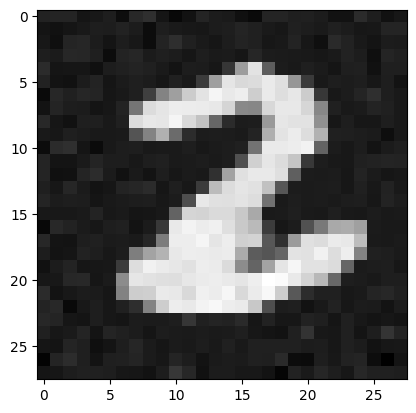

In [10]:
plt.imshow(generated[-1][0], cmap='gray')

In [14]:
# run generate_context_raw on contexts from 0 to 9
contexts = tf.one_hot([i for i in range(10)], 10)
contexts = tf.reshape(contexts, (1, 10, 10))

generated = df.generate_context_raw(
    model, 1, contexts, T, alphas, betas, alphas_cumprod
)

  0%|          | 0/999 [00:00<?, ?it/s]

: 